# cosmoprimo examples

## Cosmology

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from cosmoprimo import *

In [2]:
# start with some vanilla cosmology
cosmo = Cosmology()
# Planck2018 TT, TE, EE, lowE, lensing and BAO data
cosmo_planck = Planck2018FullFlatLCDM()
# custom cosmology
cosmo_custom = Cosmology(omega_cdm=0.2,sigma8=0.7)
print('You can provide the following parameters (including conflicts):',
      cosmo.get_default_parameters(include_conflicts=True))

You can provide the following parameters (including conflicts): {'h': 0.7, 'Omega_cdm': 0.25, 'Omega_b': 0.05, 'Omega_k': 0.0, 'sigma8': 0.8, 'k_pivot': 0.05, 'n_s': 0.96, 'alpha_s': 0.0, 'r': 0.0, 'T_cmb': 2.7255, 'N_ur': None, 'm_ncdm': None, 'neutrino_hierarchy': None, 'T_ncdm': 0.71611, 'N_eff': 3.046, 'tau_reio': 0.06, 'reionization_width': 0.5, 'A_L': 1.0, 'w0_fld': -1.0, 'wa_fld': 0.0, 'cs2_fld': 1.0, 'H0': 0.7, 'omega_cdm': 0.25, 'Omega0_cdm': 0.25, 'omega_b': 0.05, 'Omega0_b': 0.05, 'A_s': 0.8, 'ln10^{10}A_s': 0.8, 'Omega_g': 2.7255, 'omega_g': 2.7255, 'Omega0_g': 2.7255, 'Omega_ur': None, 'omega_ur': None, 'Omega0_ur': None, 'z_reio': 0.06, 'non_linear': '', 'modes': 's', 'lensing': False, 'z_pk': None, 'kmax_pk': 10.0, 'ellmax_cl': 2500}


In [3]:
# input and easily derived parameters can be accessed through indexing
print('h',cosmo['h'],cosmo_custom['h'])
print('Omega_cdm',cosmo['Omega_cdm'],cosmo_custom['Omega_cdm'])

h 0.7 0.7
Omega_cdm 0.25 0.4081632653061225


## Engines

In [4]:
# cosmological calculation is performed by engines. These can be set once for all as:
cosmo = Cosmology(engine='class')
# or :
cosmo.set_engine(engine='camb')
# or you can pass an engine instance directly
cosmo.set_engine(engine=cosmo.engine) # CLASS engine was attached to cosmo with the previous call
# then you don't need to specify it when calling specific sections, e.g.
ba = cosmo.get_background()
# or :
ba = Background(cosmo)
assert ba.engine is cosmo.engine
# you can temporarily swith to another engine with:
ba = cosmo.get_background(engine='camb',set_engine=False)
# or :
ba = Background(cosmo,engine='camb',set_engine=False)
assert cosmo.engine is not ba.engine # class engine

## Background

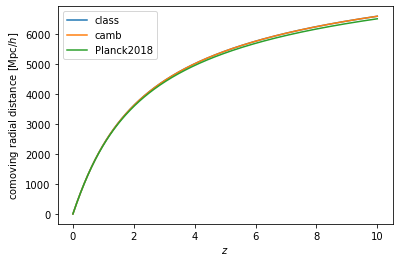

In [5]:
# you can choose an engine ('class','camb','eisenstein_hu' for approximations) for the calculation
# do ba = Background(cosmo,engine='class') or:
ba = cosmo.get_background(engine='class') # e.g. precision parameters can be passed as other arguments
ba_camb = Background(cosmo,engine='camb') # alternative way of getting background
z = np.linspace(0.,10.,1000)
plt.plot(z,ba.comoving_radial_distance(z),label='class')
plt.plot(z,ba_camb.comoving_radial_distance(z),label='camb')
plt.plot(z,cosmo_planck.get_background(engine='class').comoving_radial_distance(z),label='Planck2018')
# redoing cosmo_planck.get_background(engine='class') will not recompute the background, it's saved one for all!
# (cosmology instance is immutable)
plt.xlabel('$z$')
plt.ylabel('comoving radial distance [$\mathrm{Mpc}/h$]')
plt.legend();

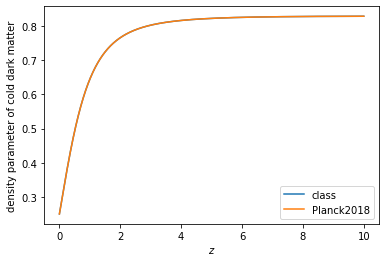

In [6]:
# many quantities are available: densities, distances;
# look at the doc (for class, look at http://github.com/adematti/pyclass)
plt.plot(z,ba.Omega_cdm(z),label='class')
plt.plot(z,ba.Omega_cdm(z),label='Planck2018')
plt.xlabel('$z$')
plt.ylabel('density parameter of cold dark matter')
plt.legend();

## You can also access thermodynamics quantities (cosmo.get_thermodynamics()), primordial quantities, etc. Let's move to...

## Perturbations

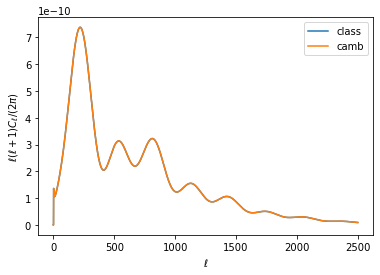

In [7]:
hr = Harmonic(cosmo,engine='class')
cls = hr.unlensed_cl()
ells_factor = (cls['ell'] + 1) * cls['ell'] / (2 * np.pi)
plt.plot(cls['ell'],ells_factor*cls['tt'],label='class')
hr = cosmo.get_harmonic(engine='camb') # second initialisation style
cls = hr.unlensed_cl() # same number of cells are output than in CLASS
plt.plot(cls['ell'],ells_factor*cls['tt'],label='camb')
plt.xlabel('$\ell$')
plt.ylabel('$\ell(\ell+1)C_{\ell}/(2\pi)$')
plt.legend();
# if you want lensed_cl(), you must set lensing=True as part of the Cosmology arguments

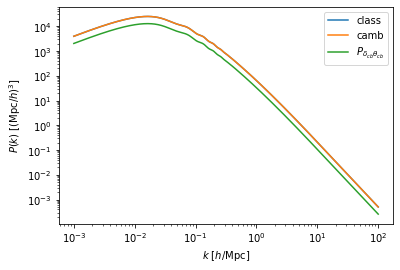

In [8]:
fo = Fourier(cosmo,engine='class')
pk = fo.pk_interpolator()
k = np.logspace(-3,2,1000)
z = 0
plt.loglog(k,pk(k,z=z),label='class')
fo_camb = cosmo.get_fourier(engine='camb') # second initialisation style
pk = fo_camb.pk_interpolator() # same number of cells are output than in CLASS
plt.loglog(k,pk(k,z=z),label='camb')
# cross density-velocity CDM + baryon power spectrum
plt.loglog(k,fo.pk_interpolator(of=('delta_cb','theta_cb'))(k,z=z),label=r'$P_{\delta_{cb}\theta_{cb}}$')
plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel('$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.legend();

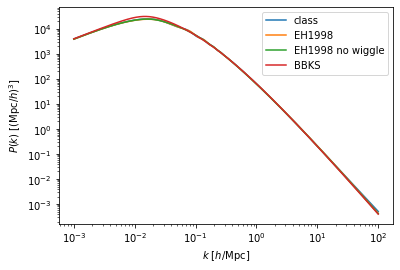

In [9]:
# fast approximations
pk = fo.pk_interpolator()
plt.loglog(k,pk(k,z=z),label='class')
plt.loglog(k,Fourier(cosmo,'eisenstein_hu').pk_interpolator()(k,z=z),label='EH1998')
plt.loglog(k,Fourier(cosmo,'eisenstein_hu_nowiggle').pk_interpolator()(k,z=z),label='EH1998 no wiggle')
plt.loglog(k,Fourier(cosmo,'bbks').pk_interpolator()(k,z=z),label='BBKS')
plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel('$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.legend();

## Note about fsgima8: should be better computed as the r.m.s. of velocity perturbations

In [10]:
fo = Fourier(cosmo,engine='class')
print('fsigma8 is',fo.sigma8_z(z=0,of='theta_cb'))

fsigma8 is 0.4102092370847631


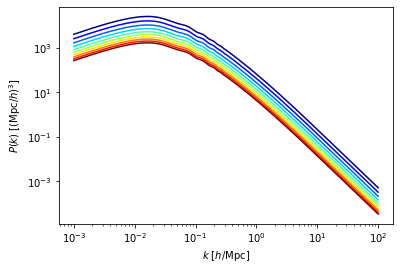

In [11]:
# as a function of z
k = np.logspace(-3,2,1000)
z = np.linspace(0.,4.,10)
colors = plt.cm.jet(np.linspace(0,1,len(z)))
for z_,color in zip(z,colors):
    plt.loglog(k,pk(k,z=z_),color=color)
plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel('$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]');

## Interpolators: easy handling of pk/xi

In [12]:
# 2D (k,z) interpolator (vectorized, of course)
pk = fo.pk_interpolator()
k, z = 0.1, 1.
print('2D power spectrum at k = {}, z = {} is {}'.format(k,z,pk(k,z)))
# cast to 1D z interpolator (tiny interpolation error)
pk1d = pk.to_1d(z=z)
print('1D power spectrum at k = {}, z = {} is {}'.format(k,z,pk1d(k)))
# interpolators can be built from callables, e.g.
pk1dc = PowerSpectrumInterpolator1D.from_callable(pk_callable=pk1d)
print('1D power spectrum from callable at k = {}, z = {} is {}'.format(k,z,pk1dc(k)))

2D power spectrum at k = 0.1, z = 1.0 is 1978.922646335354
1D power spectrum at k = 0.1, z = 1.0 is 1978.9226463353507
1D power spectrum from callable at k = 0.1, z = 1.0 is 1978.9226463353507


In [13]:
# get sigma_rz() (vectorised)
r,z = 2.,1.
print('quadpack integration sigmarz = {} v.s. FFTlog sigmarz = {}'.format(pk.sigma_rz(r,z,nk=None),pk.sigma_rz(r,z)))
# estimate fsigma_rz()
print('quadpack integration fsigmarz = {} v.s. FFTlog fsigmarz = {}'.format(pk.growth_rate_rz(r,z,nk=None),pk.growth_rate_rz(r,z)))

quadpack integration sigmarz = 1.079305763662922 v.s. FFTlog sigmarz = 1.0793023661367682
quadpack integration fsigmarz = 0.8690222636222322 v.s. FFTlog fsigmarz = 0.8689120575404441


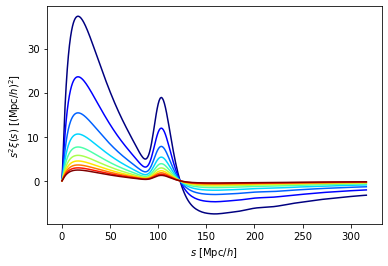

In [14]:
# FFTlog transform (vectorised) to xi...
xi = pk.to_xi()
s = np.logspace(-2.,2.5,1000)
z = np.linspace(0.,4.,10)
colors = plt.cm.jet(np.linspace(0,1,len(z)))
for z_,color in zip(z,colors):
    plt.plot(s,s**2*xi(s,z=z_),color=color)
plt.xlabel('$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^{2}\xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]');

## BAO filters

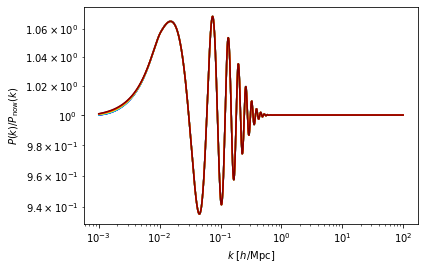

In [15]:
# several engines are available for the power spectrum, but wallish2018 is the most accurate one
# note one can also provide a 1D power spectrum interpolator
pknow = PowerSpectrumBAOFilter(pk,engine='wallish2018').smooth_pk_interpolator()
k = np.logspace(-3,2,1000)
z = np.linspace(0.,4.,10)
colors = plt.cm.jet(np.linspace(0,1,len(z)))
for z_,color in zip(z,colors):
    plt.loglog(k,pk(k,z=z_)/pknow(k,z=z_),color=color)
plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel('$P(k)/P_{\mathrm{now}}(k)$');

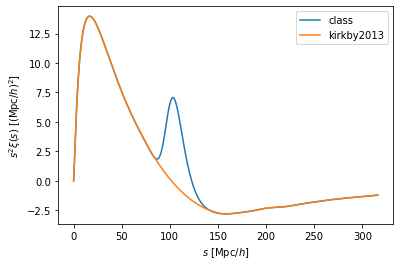

In [16]:
# for the correlation function, the Kirkby2013 approach
xinow = CorrelationFunctionBAOFilter(xi,engine='kirkby2013').smooth_xi_interpolator()
s = np.logspace(-2.,2.5,1000)
z = 1
plt.plot(s,s**2*xi(s,z=z),label='class')
plt.plot(s,s**2*xinow(s,z=z),label='kirkby2013')
plt.xlabel('$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^{2}\xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.legend();